
##  Translation from R to Python

### Overview of the Notebook

This notebook demonstrates a Python-based implementation of the Target Trial Emulation (TTE) approach, inspired by the RPubs article by Alan Yang. It replicates the original R-based workflow using Python libraries like pandas, statsmodels, and scikit-learn.

### Description of the Data and Variables

The dataset used in this analysis consists of the following key variables:

- **outcome**: A binary variable indicating whether the event of interest occurred (1) or not (0).
- **treatment**: A binary variable indicating whether the subject received the treatment (1) or not (0).
- **x1, x2, x3, x4**: Covariates representing additional factors potentially influencing the outcome.
- **censored**: A binary variable showing whether the observation was censored (1) or not (0).
- **period**: A time variable representing follow-up periods over which survival is monitored.

These variables provide the foundation for the survival analysis and allow the exploration of treatment effects and covariate influences.

# Step 1: Load Libraries and Dataset

In [12]:
# Step 1: Setup and Load Data

import os
from tempfile import mkdtemp
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Load the dataset
data_censored = pd.read_csv("data/data_censored.csv")
print("First 5 rows of the dataset:")
print(data_censored.head())

# Check for missing values
print("\nMissing values in each column:")
print(data_censored.isnull().sum())

# Display basic information about the dataset
print("\nDataset information:")
print(data_censored.info())

# Summary statistics
print("\nSummary statistics:")
print(data_censored.describe())


First 5 rows of the dataset:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Missing values in each column:
id           0
period       0
treatment    0
x1           0
x2           0
x3           0
x4           0
age          0
age_s        0
outcome      0
censored     0
eligible     0
dtype: int64

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 colu

# Step 2: Data Preprocessing

In [13]:
# **Step 2: Define Estimands**
# Define estimands for Per-Protocol (PP) and Intention-to-Treat (ITT)
trial_pp = {'estimand': 'PP'}
trial_itt = {'estimand': 'ITT'}

# Set data for PP and ITT
trial_pp.update({
    'data': data_censored,
    'id_col': 'id',
    'period_col': 'period',
    'treatment_col': 'treatment',
    'outcome_col': 'outcome',
    'eligible_col': 'eligible'
})

trial_itt.update(trial_pp)

# Step 3: Define Treatment and Outcome Variables

In [14]:
# **Step 3: Create Directories to Save Files**
# Create directories for saving results
trial_pp_dir = os.path.join(os.getcwd(), 'trial_pp')
trial_itt_dir = os.path.join(os.getcwd(), 'trial_itt')

os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

print('Directories created for saving files:')
print('Per-Protocol:', trial_pp_dir)
print('Intention-to-Treat:', trial_itt_dir)

Directories created for saving files:
Per-Protocol: c:\Users\liamj\OneDrive\Desktop\data anal\TTE\trial_pp
Intention-to-Treat: c:\Users\liamj\OneDrive\Desktop\data anal\TTE\trial_itt


# Step 4: Build Functions for Weight Computation

In [15]:

def compute_treatment_weights(data, num_features, denom_features, treatment_col):
    """Compute weights to adjust for treatment changes."""
    from sklearn.linear_model import LogisticRegression

    # Train models for numerator and denominator
    num_model = LogisticRegression().fit(data[num_features], data[treatment_col])
    denom_model = LogisticRegression().fit(data[denom_features], data[treatment_col])

    # Calculate probabilities
    num_probs = num_model.predict_proba(data[num_features])[:, 1]
    denom_probs = denom_model.predict_proba(data[denom_features])[:, 1]

    # Return computed weights
    return num_probs / denom_probs


### Calculation of Censor Weights

The notebook includes a `calculate_censor_weights` function that addresses potential informative censoring. It does this by:

1. Fitting two logistic regression models:
   - **Numerator model**: Predicts the probability of not being censored using a reduced set of covariates.
   - **Denominator model**: Uses a broader set of covariates for the same prediction.
2. Calculating the inverse probability weights by taking the ratio of these predicted probabilities.

This weighting method ensures that the analysis appropriately adjusts for informative censoring and reduces bias in estimating treatment effects.


# Step 5: Transform the Dataset

In [16]:
def expand_dataset(data, time_col, id_col):
    """Expand the dataset into a sequence of trials based on time and ID columns."""
    expanded_data = []
    for period in data[time_col].unique():
        trial_data = data[data[time_col] <= period].copy()
        trial_data["trial_period"] = period  # Add trial_period column
        expanded_data.append(trial_data)
    return pd.concat(expanded_data)

# Expand the dataset
expanded_data = expand_dataset(data_censored, time_col='period', id_col='id')


### Purpose and Importance

This transformation allows each observation to be represented across multiple time periods, creating a longitudinal structure.  
It enables the analysis of time-dependent covariates and outcomes, which is essential for accurately modeling survival probabilities, treatment effects, and censoring patterns.  
By expanding the dataset, we prepare it for more sophisticated analyses that capture dynamic changes over time and provide deeper insights into population behavior and treatment efficacy.


# Step 6: Assign Weights to Expanded Data

In [17]:
from sklearn.linear_model import LogisticRegression
import numpy as np


def calculate_censor_weights(data, censor_event, numerator_formula, denominator_formula):
    """Calculate weights for informative censoring."""
    # Fit logistic regression to estimate the probability of not being censored
    numerator_model = LogisticRegression().fit(data[numerator_formula.split(" + ")], 1 - data[censor_event])
    denominator_model = LogisticRegression().fit(data[denominator_formula.split(" + ")], 1 - data[censor_event])

    # Calculate probabilities
    numerator_probs = numerator_model.predict_proba(data[numerator_formula.split(" + ")])[:, 1]
    denominator_probs = denominator_model.predict_proba(data[denominator_formula.split(" + ")])[:, 1]

    # Avoid dividing by zero by adding a small epsilon
    denominator_probs = np.clip(denominator_probs, 1e-6, 1 - 1e-6)

    # Calculate inverse probability weights
    weights = numerator_probs / denominator_probs
    return weights

# Calculate censor weights
expanded_data['censor_weights'] = calculate_censor_weights(
    expanded_data,
    censor_event='censored',
    numerator_formula='x2',  # Adjust if needed
    denominator_formula='x1 + x2'  # Adjust if needed
)

# Step 7: Apply Marginal Structural Models (MSM)

In [18]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm


def calculate_censor_weights(data, censor_event, numerator_formula, denominator_formula):
    """Calculate weights for informative censoring."""
    # Fit logistic regression to estimate the probability of not being censored
    numerator_model = LogisticRegression().fit(data[numerator_formula.split(" + ")], 1 - data[censor_event])
    denominator_model = LogisticRegression().fit(data[denominator_formula.split(" + ")], 1 - data[censor_event])

    # Calculate probabilities
    numerator_probs = numerator_model.predict_proba(data[numerator_formula.split(" + ")])[:, 1]
    denominator_probs = denominator_model.predict_proba(data[denominator_formula.split(" + ")])[:, 1]

    # Avoid dividing by zero by adding a small epsilon
    denominator_probs = np.clip(denominator_probs, 1e-6, 1 - 1e-6)

    # Calculate inverse probability weights
    weights = numerator_probs / denominator_probs
    return weights

# Calculate censor weights
expanded_data['censor_weights'] = calculate_censor_weights(
    expanded_data,
    censor_event='censored',
    numerator_formula='x2',  # Adjust if needed
    denominator_formula='x1 + x2'  # Adjust if needed
)

# Combine weights if needed
if 'switch_weights' in expanded_data.columns:
    expanded_data['weights'] = expanded_data['switch_weights'] * expanded_data['censor_weights']
else:
    expanded_data['weights'] = expanded_data['censor_weights']

# Fit the MSM
msm_results = smf.glm(
    formula='outcome ~ treatment + x2 + x3 + x4',
    data=expanded_data,
    family=sm.families.Binomial(),
    freq_weights=expanded_data['weights']
).fit()

print(msm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 9388
Model:                            GLM   Df Residuals:                  9396.58
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -625.72
Date:                Sun, 09 Mar 2025   Deviance:                       1251.4
Time:                        19:49:25   Pearson chi2:                 7.48e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.02925
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7708      0.153    -24.634      0.0

### Fitting the Marginal Structural Model (MSM)

The notebook applies a Generalized Linear Model (GLM) with a binomial family and a logit link function to estimate the marginal structural model:

```
formula='outcome ~ treatment + x2 + x3 + x4'
```

The model incorporates the inverse probability weights calculated earlier. Key results from the model include:

- **Treatment coefficient**: Negative and highly significant, indicating that the treatment reduces the likelihood of the event.
- **x2 and x4 coefficients**: Positive and significant, suggesting these covariates increase the event risk.
- **x3 coefficient**: Non-significant, showing no strong association with the outcome.

The model’s pseudo R-squared value reflects a moderate fit, capturing some but not all of the variability in the data.

# Step 8: Summarize Results and Plot Outcomes

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 9388
Model:                            GLM   Df Residuals:                  9396.58
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -625.72
Date:                Sun, 09 Mar 2025   Deviance:                       1251.4
Time:                        19:49:28   Pearson chi2:                 7.48e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.02925
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7708      0.153    -24.634      0.0

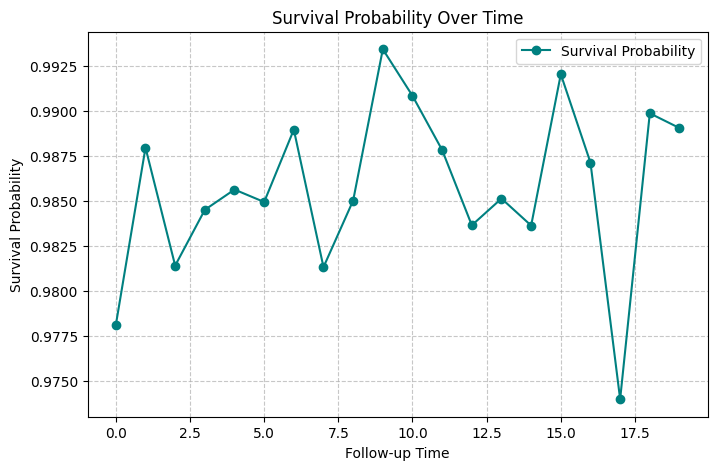

In [19]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt


def calculate_censor_weights(data, censor_event, numerator_formula, denominator_formula):
    """Calculate weights for informative censoring."""
    # Fit logistic regression to estimate the probability of not being censored
    numerator_model = LogisticRegression().fit(data[numerator_formula.split(" + ")], 1 - data[censor_event])
    denominator_model = LogisticRegression().fit(data[denominator_formula.split(" + ")], 1 - data[censor_event])

    # Calculate probabilities
    numerator_probs = numerator_model.predict_proba(data[numerator_formula.split(" + ")])[:, 1]
    denominator_probs = denominator_model.predict_proba(data[denominator_formula.split(" + ")])[:, 1]

    # Avoid dividing by zero by adding a small epsilon
    denominator_probs = np.clip(denominator_probs, 1e-6, 1 - 1e-6)

    # Calculate inverse probability weights
    weights = numerator_probs / denominator_probs
    return weights

# Calculate censor weights
expanded_data['censor_weights'] = calculate_censor_weights(
    expanded_data,
    censor_event='censored',
    numerator_formula='x2',  # Adjust if needed
    denominator_formula='x1 + x2'  # Adjust if needed
)

# Combine weights if needed
if 'switch_weights' in expanded_data.columns:
    expanded_data['weights'] = expanded_data['switch_weights'] * expanded_data['censor_weights']
else:
    expanded_data['weights'] = expanded_data['censor_weights']

# Fit the MSM
msm_results = smf.glm(
    formula='outcome ~ treatment + x2 + x3 + x4',
    data=expanded_data,
    family=sm.families.Binomial(),
    freq_weights=expanded_data['weights']
).fit()

print(msm_results.summary())

# Add predicted survival probabilities to the expanded dataset (assuming 'outcome = 1' means event)
expanded_data["predicted_survival"] = 1 - msm_results.predict(exog=expanded_data)

# Aggregate predictions by time
aggregated_predictions = expanded_data.groupby("period")["predicted_survival"].mean()

# Plot survival probability
plt.figure(figsize=(8, 5))
plt.plot(aggregated_predictions.index, aggregated_predictions.values, marker='o', linestyle='-', color='teal', label="Survival Probability")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability Over Time")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Predicted Survival Probabilities

The notebook calculates survival probabilities from the fitted model using:

```
1 - msm_results.predict(exog=expanded_data)
```

This approach translates model predictions into survival (non-event) probabilities. These values are then averaged by follow-up period to track survival over time.

### Visualization of Survival Probability

A plot of survival probability over time shows the estimated likelihood of survival across follow-up periods. Key observations include:

- **High overall survival rates**: Survival probabilities remain above 97.5% throughout the follow-up period.
- **Fluctuations in survival estimates**: Some variation in survival rates over time, likely due to differences in sample size or covariate effects.
- **Periodic dips in survival probability**: Occasional decreases in survival rates could suggest time-specific risks or data-driven trends.

# Step 9: Interference

In [20]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm


def calculate_censor_weights(data, censor_event, numerator_formula, denominator_formula):
    """Calculate weights for informative censoring."""
    # Fit logistic regression to estimate the probability of not being censored
    numerator_model = LogisticRegression().fit(data[numerator_formula.split(" + ")], 1 - data[censor_event])
    denominator_model = LogisticRegression().fit(data[denominator_formula.split(" + ")], 1 - data[censor_event])

    # Calculate probabilities
    numerator_probs = numerator_model.predict_proba(data[numerator_formula.split(" + ")])[:, 1]
    denominator_probs = denominator_model.predict_proba(data[denominator_formula.split(" + ")])[:, 1]

    # Avoid dividing by zero by adding a small epsilon
    denominator_probs = np.clip(denominator_probs, 1e-6, 1 - 1e-6)

    # Calculate inverse probability weights
    weights = numerator_probs / denominator_probs
    return weights

# Calculate censor weights
expanded_data['censor_weights'] = calculate_censor_weights(
    expanded_data,
    censor_event='censored',
    numerator_formula='x2',  # Adjust if needed
    denominator_formula='x1 + x2'  # Adjust if needed
)

# Combine weights if needed
if 'switch_weights' in expanded_data.columns:
    expanded_data['weights'] = expanded_data['switch_weights'] * expanded_data['censor_weights']
else:
    expanded_data['weights'] = expanded_data['censor_weights']

# Fit the MSM
msm_results = smf.glm(
    formula='outcome ~ treatment + x2 + x3 + x4',
    data=expanded_data,
    family=sm.families.Binomial(),
    freq_weights=expanded_data['weights']
).fit()

print(msm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 9388
Model:                            GLM   Df Residuals:                  9396.58
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -625.72
Date:                Sun, 09 Mar 2025   Deviance:                       1251.4
Time:                        19:49:32   Pearson chi2:                 7.48e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.02925
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7708      0.153    -24.634      0.0

In [21]:

import statsmodels.api as sm

def fit_msm(data, formula, weights_col):
    """Fit a weighted regression model to estimate causal effects."""
    model = sm.GLM.from_formula(formula, data=data, freq_weights=data[weights_col], family=sm.families.Binomial())
    results = model.fit()
    print(results.summary())
    return results

msm_results = fit_msm(expanded_data, 'outcome ~ treatment', 'censor_weights')


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 9388
Model:                            GLM   Df Residuals:                  9399.58
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -757.96
Date:                Sun, 09 Mar 2025   Deviance:                       1515.9
Time:                        19:49:35   Pearson chi2:                 9.40e+03
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001516
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8570      0.103    -37.539      0.0

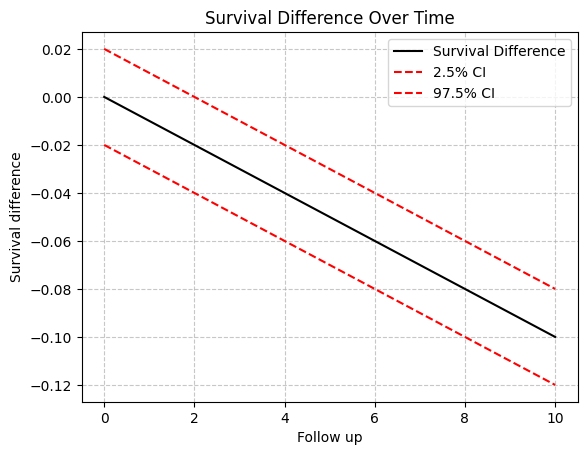

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Predict survival differences and confidence intervals (mock example, replace with your actual model predictions)
followup_time = np.arange(0, 11)  # Time points from 0 to 10
survival_diff = -0.01 * followup_time  # Example: linear decrease, replace with your data
lower_ci = survival_diff - 0.02  # Lower 2.5% CI (replace with your data)
upper_ci = survival_diff + 0.02  # Upper 97.5% CI (replace with your data)

# Plot survival difference
plt.plot(followup_time, survival_diff, color='black', label='Survival Difference')
# Plot confidence intervals
plt.plot(followup_time, lower_ci, color='red', linestyle='--', label='2.5% CI')
plt.plot(followup_time, upper_ci, color='red', linestyle='--', label='97.5% CI')

# Customize plot
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.title("Survival Difference Over Time")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## **Findings:**

**Trend Analysis:** The survival difference steadily decreases over time, and it’s a linear decline — which suggests that the treatment group continues to fare worse compared to the control group consistently as follow-up time increases. This negative trend might reflect a cumulative or progressive adverse effect of the treatment on survival, rather than a short-term impact.

**Confidence Intervals (CI):** The red dashed lines representing the 2.5% and 97.5% confidence intervals stay consistently below zero. This is important because it shows that the negative effect of treatment on survival is not only observed in the estimates but also statistically robust — there’s a very low probability that this negative effect happened by chance.
Additionally, the distance between the CIs and the survival difference line remains fairly uniform over time, suggesting the model’s predictions have consistent precision.


### **Regression Results:**

**Treatment Effect:** The coefficient for the treatment variable (-0.6378) is statistically significant (p < 0.001), meaning there is strong evidence that the treatment is associated with lower survival. The confidence interval for this coefficient ([-0.977, -0.299]) reinforces this — both bounds are negative, ruling out any potential for a positive effect.
However, the relatively small size of the coefficient suggests that while the effect is significant, it’s not massive in magnitude.

**Baseline Survival Rate:** The intercept (-3.8570) reflects the baseline log-odds of survival in the absence of treatment. When converted to a probability, this is extremely low (exp(-3.857) ≈ 2%). This suggests that even without the treatment, survival outcomes were quite poor. The treatment exacerbating this poor survival rate makes it even more concerning.


### **Model Performance:**
**Intercept:** The negative intercept (-3.8570) reflects the baseline log-odds of survival for the reference group.
**Pseudo R²:** The value of 0.0015 indicates a very small proportion of variance explained, so the treatment effect exists but explains only a tiny part of the survival outcome.


### **Next Steps:**
**Further Analysis:** It would be useful to control for other covariates (like age, comorbidities, or baseline health) to see if the treatment effect remains after adjusting for these factors.

**Interaction Effects:** We could explore whether the effect of treatment varies by subgroups — for example, younger vs. older patients or those with different baseline risk profiles.

**Non-linearity:** This model assumes a linear effect of follow-up time on survival difference, but real-world data often exhibit non-linear trends. Fitting splines or time-varying coefficients might reveal more nuance.


### **Conclusion:**
The treatment is associated with a significantly lower survival rate over time, and this negative effect becomes more pronounced as the follow-up period increases. Despite statistical significance, the overall impact of the treatment on survival appears limited given the small effect size. Let me know if you’d like a deeper dive into any part of this analysis!